# PHY 266 HW 4

In [1]:
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import glob

from math import pi
from scipy import special
from astropy.io import fits 
from astropy.table import QTable

## Prb 1. Resampling

### 1 a) Central limit theorem (CLT) states that when a statistic is calculated by adding some random variables regardless of their inherent distribution, then the distribution of the statistic itself will be a noramal distribution. However here we are multiplying some random variables rather than adding which doesn't fullfill CLT criteria. So we should not use CLT to  calculate confidance intervel of that multiplicative statistic.

### 1 b)

In [2]:
mass = np.array([0.52276697, 0.67990908, 0.99673325, 0.15502455, 0.27850341, 0.2602331,
                 0.29049269, 0.82442712, 0.18945119, 0.1222666])

In [3]:
sample = 50000
resampled_m = []
for i in range(sample):
    resampled_m.append(np.random.choice(mass,size=len(mass),replace=True))

In [4]:
resampled_m = np.asarray(resampled_m)
resampled_m.shape

(50000, 10)

In [5]:
mass_prod = np.zeros(sample)
for i,p in enumerate(resampled_m):
    #print(p)
    mass_prod[i] = np.prod(p)* 2*10**31
#print(mass_prod)

<IPython.core.display.Javascript object>


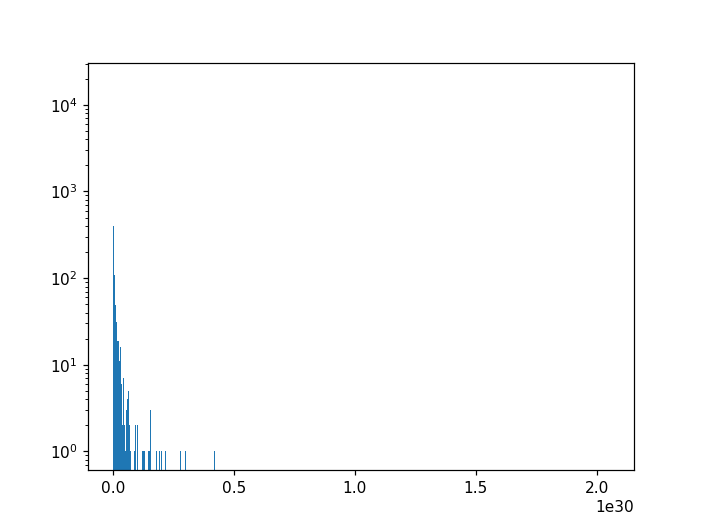

In [6]:
%matplotlib notebook
count, bins, patch = plt.hist(mass_prod,bins=10000, log=True)

### This histogram does not look like a Gaussian distribution at all. 

### 1 c) We can see most of the samples are congregrated at the lower side of the histogram. And the histogram is not symmetric about the mean so it only makes sense to have an upper limit. Or as we already know from the histogram that the samples are not going to be much lower than the lowest value in the histogram so we can only ask what percentage of samples are below some upper limit. 

In [7]:
sm = 0
cnt = 0
flag1 = 1
flag2 = 1
flag3 = 1
tot = mass_prod.flatten().shape[0]

for j,p in enumerate(count):
    if p > cnt:
        cnt = p
        max_bin = bins[j]
    sm += p
    if sm/tot >= 0.683 and flag1:
        border1 = 0.5*(bins[j+1] + bins[j])
        flag1 = 0
    elif sm/tot >= 0.955 and flag2:
        border2 = 0.5*(bins[j+1] + bins[j])
        flag2 = 0
    elif sm/tot >= 0.997 and flag3:
        border3 = 0.5*(bins[j+1] + bins[j])
        flag3=0

In [8]:
print("\n68.3%% upper limit : %e" %border1)
print("\n95.5%% upper limit : %e" %border2)
print("\n99.7%% upper limit : %e" %border3)


68.3% upper limit : 1.332144e+27

95.5% upper limit : 1.813599e+28

99.7% upper limit : 1.669115e+29


In [9]:
m1 = mass_prod < 1.332144e+27
print("\npercentage of samples upto %e is %.3f%%" %(1.332144e+27, np.sum(1*m1) /tot))

m1 = mass_prod < 1.813599e+28
print("\npercentage of samples upto %e is %.3f%%" %(1.813599e+28, np.sum(1*m1) /tot))

m1 = mass_prod < 1.669115e+29
print("\npercentage of samples upto %e is %.3f%%" %(1.669115e+29, np.sum(1*m1) /tot))



percentage of samples upto 1.332144e+27 is 0.696%

percentage of samples upto 1.813599e+28 is 0.955%

percentage of samples upto 1.669115e+29 is 0.997%


### 1 d) To calculate a p value we need to have a model for the null hypothesis which defines the distribution of the range of outcomes. Here as we don't have any such model we shouldn't  calculate a p-value.

## Prb 2. Cosmic ray rejection and medianizing.

### 2 a) 

In [10]:
spec1 = fits.open('../data/spectra/DE.20140622.50430.fits')[1].data
spec2 = fits.open('../data/spectra/DE.20140622.51400.fits')[1].data
spec3 = fits.open('../data/spectra/DE.20140622.52273.fits')[1].data

In [11]:
combined = np.array([spec1, spec2, spec3])

In [12]:
median_image = np.median(combined, axis=0)

In [14]:
fits.PrimaryHDU(median_image).writeto('median_image.fits')

### 2 b). I have attched a screen shot showing same 2d pixel region for all the three spectra image and their median image. The region I am showing has pixel range (x,y)=(1046:1281, 2083:2464). In the screen shot the first three frames have the three spectra and the forth frame has their median imgae.

### 2 c) We should not apply this to any set of images. This procedure is applicable only to the set of images which have been taken at the same location on the sky or the same source, preferably at same night with similar instrumental setup and most importantly for same exposure time. If the source or the exposure time is different then we can not comapre pixel counts at the same pixel location in those set of images.

## Prb 3. Non-Gaussian scatter

### 3 a)  To find out the p value we first need to calculate the survival function for this distribution. As only the distance of the star from the galaxy center is physically meaningful not whether the star is on the left or right of the center so we can neglect the sign of the distances. The cumulative distribution function would be
$$\begin{align}
  F(x) &=  \int_{-\infty}^{x} f(x')dx' \\
       &= \frac{1}{x_0}\int_{-\infty}^{x} e^{−\frac{|x'|}{x_0}}dx' \\ 
       &= \frac{1}{x_0}\int_{0}^{x} e^{-\frac{x'}{x_0}}dx' \\
       &= 1 - e^{−\frac{x}{x_0}}  \\
\end{align}$$

### Then the survival function or PTE is $1-F(x)= e^{−\frac{x}{x_0}}$.  So the p-value for x=17 arcsec is 0.0333.

In [15]:
np.exp(-(17/5))

0.03337326996032608

### 3 b) To test the hypothesis that any star in a disk galaxy is equally likely to go supernova, regardless of its distance from the center, first we need to have a model for the distribution of stars (which may explode as supernova in future) in the galaxy. From part a we can assume that the distribution of stars would be an exponential function. We can then have a CDF for this model PDF. Then to calculate the p value for the data in the catalog we can do a KS test and calculate to what extent the data differes from the model. 

### If we are interested in the hypothesis that supernova preferentially occur on the outskirts all we have have to do is to change the model a litle bit. Instead of having a exponential distribution where the distances are measured from the center we need to measure the distance from a predefined normalized distance close to the outskirt. The new distribution would be like $\frac{1}{x_0} e^{−\frac{|x -x_1|}{x_0}}$ where $x_1$ is the predefined distance from the center in the proximity of the outskirt. This model suggests that the number of stars which explodes as supernova are more likely at the distance $x_1$ and exponentially less likely if the distances increase from that position. Both the $x$ and $x_1$ are normalized in terms of $x_0$ which will vary from galaxy to galaxy to treat all the distances in equal footing. Then again we will do a KS test (two sided p value test) for the data in the catalog to calculate the p value.